https://colab.research.google.com/drive/1wULcUjpzmrTuuivUSe1tokqEexPaerpB?usp=sharing

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell


# Colab related import
from google.colab import drive

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(directory):
    # List to store the DataFrames
    dataframes = []

    # Iterate over each CSV file in the directory
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            if 'datetime' not in df.columns:
                df = pd.read_csv(file_path, header=1)
            dataframes.append(df)

    # Concatenate all DataFrames into one
    df = pd.concat(dataframes)
    df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%dT%H:%M:%S")

    return df

# Directory where the CSV files are located for Colchester and load data
directory_colchester = '/content/drive/MyDrive/Colab Notebooks/CE888/Colchester'
df_colchester = load_data(directory_colchester)

# Directory where the CSV files are located for Brighton and load data
directory_brighton = '/content/drive/MyDrive/Colab Notebooks/CE888/Brighton'
df_brighton = load_data(directory_brighton)


In [ ]:
df_brighton.sort_values(by='datetime', ascending=True, inplace=True)
df_brighton.set_index('datetime', inplace=True)
df_brighton['solarenergy'].isna().any() #just to verify
df_brighton.head()


,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,"rain,snow",0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,NaN,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,NaN,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,NaN,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,NaN,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0


In [ ]:
print(df_brighton.index.duplicated().any())
# Let's create a new df so we can work from it without modify the original
df = df_brighton.copy()

# if we rmove duplicates based on all columns, there will be still duplicates so
#this doesn't works df = df.drop_duplicated()
df = df[~df.index.duplicated(keep='first')]
# Set 'datetime' as the index again


# Check if there are any duplicated indices
print(df.index.duplicated().any())
#Now we can reindex
df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='H'))
print(len(df))


True
False
122844


In [ ]:
# Create a boolean mask to identify rows with missing values in the 'solarenergy' column
nulls_solar = df['solarenergy'].isna()

# Shift the values in all columns by 8760 periods (one year)
# to fill the missing values with values from the same period one year ago
df.loc[nulls_solar] = df.shift(8760)  # 8760 periods in a year


In [ ]:
# Create a boolean mask to identify rows with missing values in the 'solarenergy' column and belonging to the year 2010
nulls_2010 = df['solarenergy'].isna() & (df.index.year == 2010)

# Shift the values in the 'solarenergy' column by 1 period backward to fill the missing values specifically for the year 2010
df.loc[nulls_2010, 'solarenergy'] = df['solarenergy'].shift(-1)


In [ ]:
 #there i ps still a null in 2011-08-12 01:00:00 so, let's repet
nulls = df['solarenergy'].isna()
df.loc[nulls, 'solarenergy'] = df['solarenergy'].shift(8760) #8760 periodos

In [ ]:
# Find null values in the 'windspeed' column
nulls = df['windspeed'].isna()

df.loc[nulls, 'windspeed'] = df['windspeed'].shift(8760) # Shift the values of 'windspeed' column by 8760 periods (assuming hourly data)

In [ ]:
# Create a boolean mask to identify rows with missing values in the 'solarenergy' column and belonging to the year 2010
nulls_2010 = df['windspeed'].isna() & (df.index.year == 2010)

df.loc[nulls_2010, 'windspeed'] = df['windspeed'].shift(-1) # Shift the values in the 'solarenergy' column by 1 period backward to fill the missing values specifically for the year 2010

In [ ]:
 #there i ps still a null in 2011-08-12 01:00:00 so, let's repet
nulls = df['windspeed'].isna()
df.loc[nulls, 'windspeed'] = df['solarenergy'].shift(8760) #8760 periodos

#and again for 2010
nulls_2010 = df['windspeed'].isna() & (df.index.year == 2010) # Create a boolean mask to identify rows with missing values in the 'solarenergy' column and belonging to the year 2010
df.loc[nulls_2010, 'windspeed'] = df['windspeed'].shift(-1) # Shift the values in the 'solarenergy' column by 1 period backward to fill the missing values specifically for the year 2010

In [ ]:
df[df['windspeed'].isna()]

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex


In [ ]:
df = df.fillna(0)
df.drop(columns=['preciptype'], inplace=True)
#column_indices = {name: i for i, name in enumerate(train_df.columns)}
print(df.index.duplicated().any())


False


Let's split the data as follows:

  
    Split 70:20:10 (train:validation:test)


In [ ]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Check the lengths of each set
print("Training set length:", len(train_df))
print("Validation set length:", len(val_df))
print("Test set length:", len(test_df))


Training set length: 85990
Validation set length: 24569
Test set length: 12285


Next, we’ll fit the scaler to the training set only, and scale each individual set.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

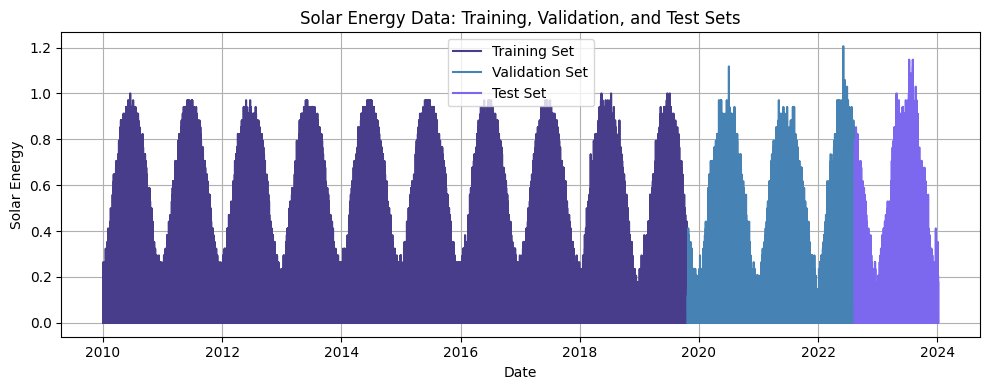

In [ ]:
# Plotting the separation of data with less vibrant colors
plt.figure(figsize=(10, 4))

# Plotting the training set
plt.plot(train_df.index, train_df['solarenergy'], label='Training Set', color='darkslateblue')
plt.plot(val_df.index, val_df['solarenergy'], label='Validation Set', color='steelblue')# Plotting the validation set
plt.plot(test_df.index, test_df['solarenergy'], label='Test Set', color='mediumslateblue')# Plotting the test set

# Adding labels and title
plt.title('Solar Energy Data: Training, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Solar Energy')
plt.legend()  # Adding legend
plt.grid(True)  # Adding grid
plt.tight_layout()
plt.show()  # Displaying the plot


the next The DataWindow class was inspired on [this book](https://learning.oreilly.com/library/view/time-series-forecasting/9781617299889/Text/18.htm#heading_id_15)  chapter 13

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='solarenergy', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

With the DataWindow class defined, we only need a function to compile and train the different models we’ll develop.

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=10):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

Baseline models

start with a baseline model

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['solarenergy'])

Next, we’ll implement a class that will repeat the last known value of the input sequence as a prediction for the next 24 hours.

In [ ]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

We can now generate predictions using this baseline and store its performance in a dictionary.

In [ ]:
baseline_last = MultiStepLastBaseline()

baseline_last.compile(loss=MeanSquaredError(),  metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline Last'] =  baseline_last.evaluate(multi_window.val)
performance['Baseline Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

767/767 [==============================] - 3s 4ms/step - loss: 0.2264 - mean_absolute_error: 0.3439


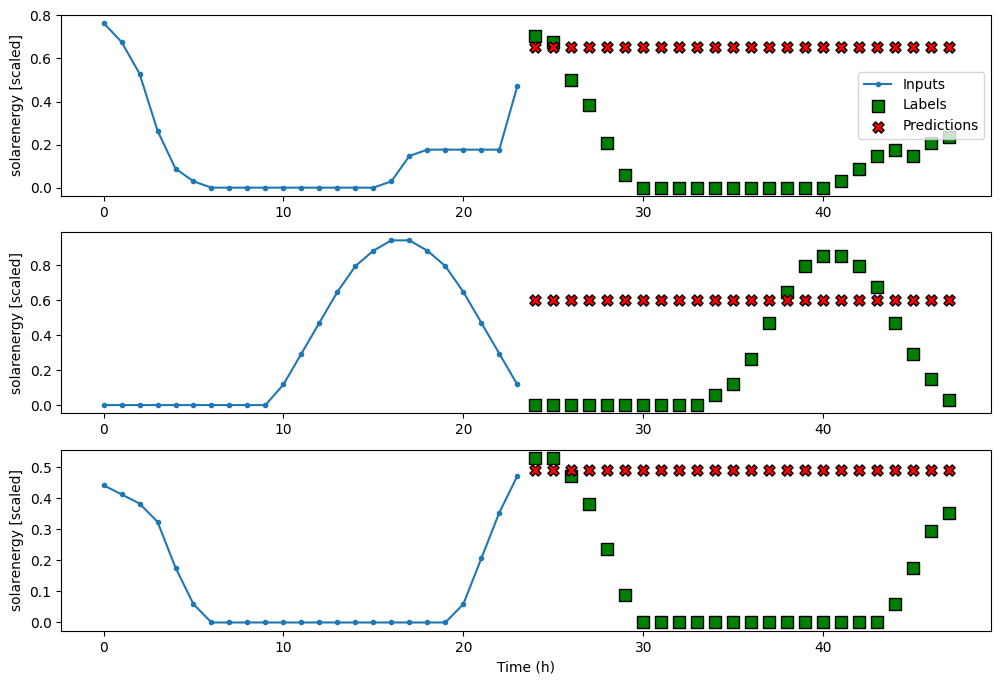

In [ ]:
multi_window.plot(baseline_last)#Lets visualize the plot

In [ ]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['solarenergy'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['solarenergy'])

In [ ]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

Implementing an LSTM as a single-step model

In [ ]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1,
                         label_columns=['solarenergy'])

In [ ]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/10
2687/2687 [==============================] - 29s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0380 - val_loss: 0.0059 - val_mean_absolute_error: 0.0394
Epoch 2/10
2687/2687 [==============================] - 23s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0270 - val_loss: 0.0057 - val_mean_absolute_error: 0.0379
Epoch 3/10
2687/2687 [==============================] - 25s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0255 - val_loss: 0.0058 - val_mean_absolute_error: 0.0413
Epoch 4/10
2687/2687 [==============================] - 25s 9ms/step - loss: 0.0021 - mean_absolute_error: 0.0245 - val_loss: 0.0055 - val_mean_absolute_error: 0.0378
Epoch 5/10
2687/2687 [==============================] - 26s 10ms/step - loss: 0.0021 - mean_absolute_error: 0.0238 - val_loss: 0.0054 - val_mean_absolute_error: 0.0364
Epoch 6/10
2687/2687 [==============================] - 25s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0233 - val_loss: 0.0053 - val_mean_absolute_error: 0.0

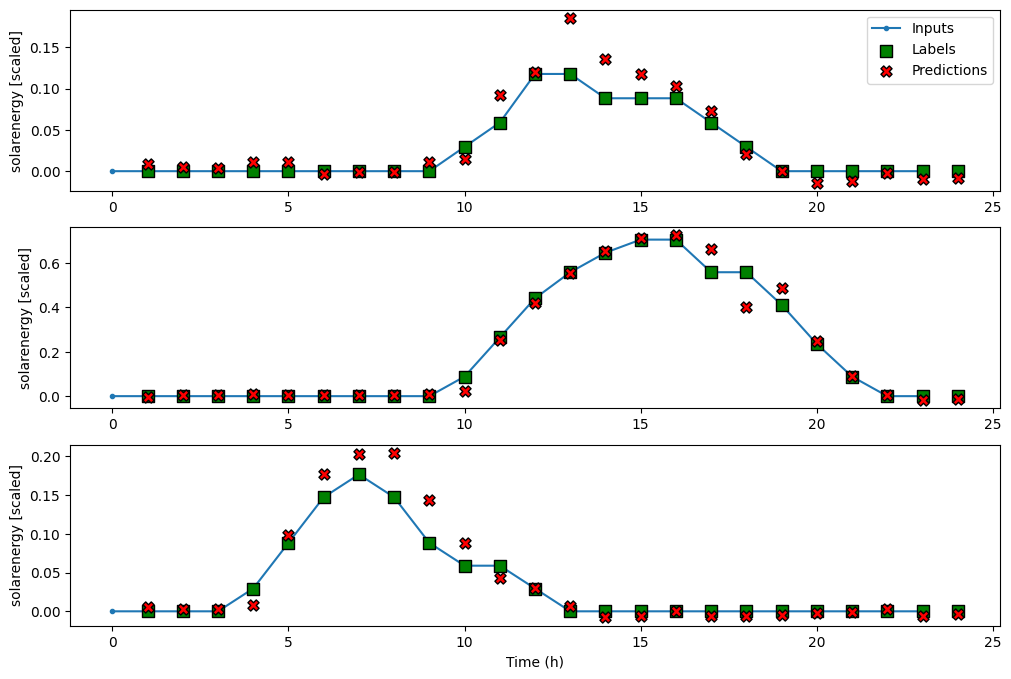

In [ ]:
wide_window.plot(lstm_model)


Implementing an LSTM as a multi-step model

In this case, we wish to predict traffic volume for next 24 hours, using an input window of 24 hours.

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24,
                          label_columns=['solarenergy'])

Then we need to define our LSTM model in Keras. Again we’ll use the Sequential model to allow us to stack different layers in our network. Keras conveniently comes with the LSTM layer, which implements an LSTM.

In [ ]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)
ms_val_performance= {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/10
2686/2686 [==============================] - 26s 9ms/step - loss: 0.0123 - mean_absolute_error: 0.0635 - val_loss: 0.0124 - val_mean_absolute_error: 0.0576
Epoch 2/10
2686/2686 [==============================] - 25s 9ms/step - loss: 0.0103 - mean_absolute_error: 0.0562 - val_loss: 0.0123 - val_mean_absolute_error: 0.0598
Epoch 3/10
2686/2686 [==============================] - 22s 8ms/step - loss: 0.0098 - mean_absolute_error: 0.0545 - val_loss: 0.0123 - val_mean_absolute_error: 0.0585
Epoch 4/10
2686/2686 [==============================] - 26s 10ms/step - loss: 0.0094 - mean_absolute_error: 0.0531 - val_loss: 0.0122 - val_mean_absolute_error: 0.0570
Epoch 5/10
2686/2686 [==============================] - 22s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0522 - val_loss: 0.0126 - val_mean_absolute_error: 0.0586
Epoch 6/10
2686/2686 [==============================] - 25s 9ms/step - loss: 0.0090 - mean_absolute_error: 0.0516 - val_loss: 0.0122 - val_mean_absolute_error: 0.05

We can visualize the predictions

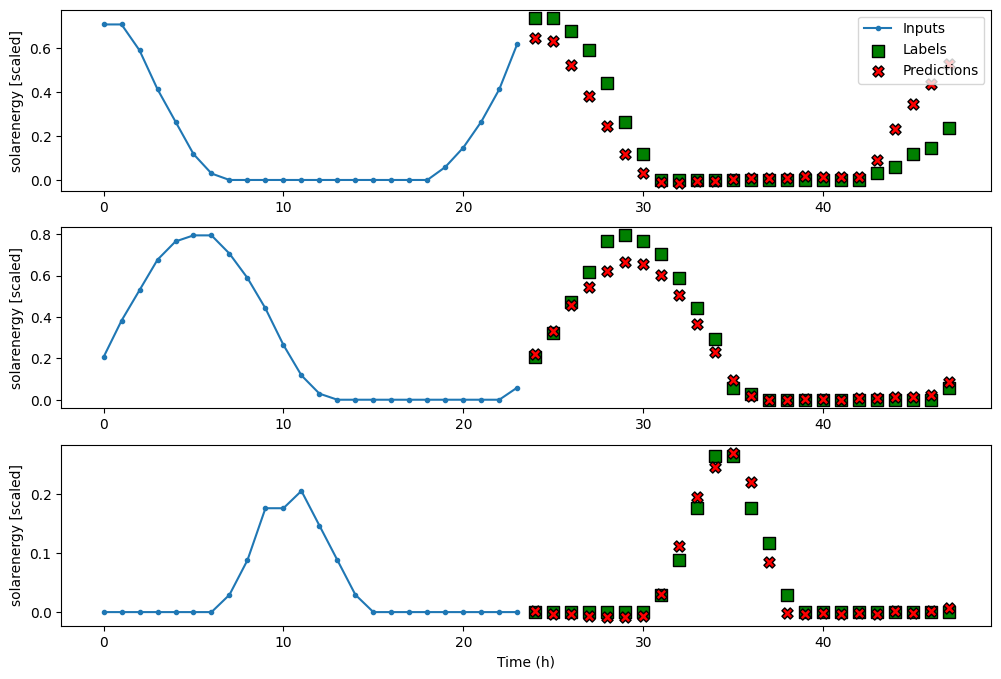

In [ ]:
multi_window.plot(ms_lstm_model)


LSTM as a multi-output model

we’ll use 24 hours of input data, so that the network can process a sequence of data points and use past information to produce forecasts.

The predictions will be for both the solar energy and wind speed at the next timestep

In [ ]:
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1,
                            label_columns=['solarenergy','windspeed'])

define our LSTM model. Just as before, we’ll use the Sequential model to stack an LSTM layer and a Dense output layer with two units, since we have two targets.


In [ ]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)   #We have two units because we have two targets
])

In [ ]:
#Then we'll train the model and store its performance metrics for comparison.

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/10
2687/2687 [==============================] - 47s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0417 - val_loss: 0.0044 - val_mean_absolute_error: 0.0394
Epoch 2/10
2687/2687 [==============================] - 45s 17ms/step - loss: 0.0026 - mean_absolute_error: 0.0328 - val_loss: 0.0043 - val_mean_absolute_error: 0.0386
Epoch 3/10
2687/2687 [==============================] - 43s 16ms/step - loss: 0.0024 - mean_absolute_error: 0.0317 - val_loss: 0.0042 - val_mean_absolute_error: 0.0379
Epoch 4/10
2687/2687 [==============================] - 41s 15ms/step - loss: 0.0024 - mean_absolute_error: 0.0312 - val_loss: 0.0040 - val_mean_absolute_error: 0.0373
Epoch 5/10
2439/2687 [==========================>...] - ETA: 3s - loss: 0.0023 - mean_absolute_error: 0.0308

We can now visualize the prediction for the solar energy and for the wind speed

In [ ]:
mo_wide_window.plot(mo_lstm_model)

In [ ]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='windspeed')

In [ ]:
# Get the Mean Absolute Error values for the three models on validation and test data
mae_val = [val_performance['LSTM'][1], ms_val_performance['LSTM'][1], mo_val_performance['LSTM'][1]]
mae_test = [performance['LSTM'][1], ms_performance['LSTM'][1], mo_performance['LSTM'][1]]

# Plot the results
models = ['LSTM', 'MS LSTM', 'MO LSTM']
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae_val, width, label='Validation')
rects2 = ax.bar(x + width/2, mae_test, width, label='Test')

ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Selecting the best model
Now let's visualize the MAE of each model to determine the champion.

The multi-output model validation has a very low MAE and it serves me well for both wind speed and solar energy, so we'll stick with that. There isn't much difference compared to LSTM.

In [ ]:
# 1. Use the forecast model to predict solar energy and wind speed for the next 24 hours
forecast_data = mo_lstm_model.predict(mo_wide_window.test)
solar_energy_forecast = forecast_data[:, 0]  # Solar energy forecast
wind_speed_forecast = forecast_data[:, 1]    # Wind speed forecast

# 2. Calculate the energy generated by solar panels and wind turbines during that period
# Formula to calculate energy generated by solar panels
def calculate_solar_energy(solar_irradiance, panel_area):
    # Convert from MJ/m² to Wh/hour
    energy_wh_hour = solar_irradiance * panel_area * 1000000 * 3.6
    return energy_wh_hour

# Assuming a solar panel area of 10 m²
solar_panel_area = 10

# Use the predicted solar energy and panel area to calculate the energy generated by solar panels
solar_energy_generated = calculate_solar_energy(solar_energy_forecast, solar_panel_area)

# Formula to calculate energy generated by wind turbines
def calculate_wind_energy(wind_speed, rotor_radius):
    # Rotor area = π * r^2
    rotor_area = 3.1416 * (rotor_radius**2)
    # Air density (kg/m³)
    air_density = 1.225
    # Calculate wind turbine power
    wind_energy = 0.5 * air_density * rotor_area * wind_speed**3
    return wind_energy

# Assuming a rotor radius of 77 meters for the wind turbines
rotor_radius = 77

# Use the predicted wind speed and rotor radius to calculate the energy generated by wind turbines
wind_energy_generated = calculate_wind_energy(wind_speed_forecast, rotor_radius)

# 3. Compare the generated energy with the estimated energy consumption by households in Brighton
# Estimated hourly consumption per household (Wh)
hourly_household_consumption = 308.22

# Total number of households in Brighton
total_households = 39000

# Total estimated hourly consumption for all households in Brighton
total_hourly_consumption = hourly_household_consumption * total_households

# Calculate the surplus of available energy
energy_surplus = (solar_energy_generated + wind_energy_generated) - total_hourly_consumption

# Print the results
print("Generated Solar Energy (Wh):")
print(solar_energy_generated)
print("\nGenerated Wind Energy (Wh):")
print(wind_energy_generated)
print("\nTotal Estimated Hourly Energy Consumption in Brighton (Wh):")
print(total_hourly_consumption)
print("\nAvailable Energy Surplus (Wh):")
print(energy_surplus)


384/384 [==============================] - 2s 6ms/step
Generated Solar Energy (Wh):
[[ -350560.42671204  1717999.07684326]
 [16182645.03479004 12480210.39962769]
 [16114437.10327148  9504642.39120483]
 ...
 [  -33435.35475433  5773259.63973999]
 [  419182.00850487  5706990.62347412]
 [  965484.30919647  6118630.31387329]]

Generated Wind Energy (Wh):
[[ 3.0296508e-04  1.0806496e+00]
 [ 4.2934731e+03  4.3739206e+02]
 [ 3.3176505e+02  1.5451422e+02]
 ...
 [-2.6536832e-04  6.4012047e+01]
 [-5.6677625e-02  1.8149978e+00]
 [-1.1005084e-02  3.4324745e+01]]

Total Estimated Hourly Energy Consumption in Brighton (Wh):
12020580.000000002

Available Energy Surplus (Wh):
[[-12371140.42640907 -10302579.84250713]
 [  4166358.50793457    460067.79168701]
 [  4094188.86831665  -2515783.09457398]
 ...
 [-12054015.3550197   -6247256.3482132 ]
 [-11601398.04817276  -6313587.56152809]
 [-11055095.70180861  -5901915.36138153]]
